In [1]:
####
## Celso Antonio Uliana Junior
## July 2 2020
####

import pandas as pd

#####
## Consuming and shaping the data to analysis
## Covid-19 numbers in Brazil by date
## Isolation percentage in Brazil by date
#####

data_raw_covid = pd.read_csv("C:/Users/PCDOMILHAO/Documents/GitHub/trab-siad/scripts/Jupyter-Notebook/dados/covidBrasil.csv", sep = ";", decimal = ",")
data_raw_isolation = pd.read_csv("C:/Users/PCDOMILHAO/Documents/GitHub/trab-siad/scripts/Jupyter-Notebook/dados/isolamento.csv", sep = ";", decimal = ",")
data_covid = data_raw_covid['Data'].values.copy()
data_covid = data_raw_covid.dropna().set_index("Data")
data_isolation = data_raw_isolation['Data'].values.copy()
data_isolation = data_raw_isolation.dropna().set_index("Data")

####
## Shaping a central pandas dataFrame for all our ML needs
####

data = data_covid
data['Taxa'] = data_isolation['Taxa'].values.copy()


In [2]:
from sklearn.preprocessing import MinMaxScaler

####
## normalizing values for both covid and isolation percentage 
## between range [0,1] using sklearn MinMaxScaler
####

covid_norm = data_covid["Casos"].values.copy()
covid_norm.shape = (len(covid_norm), 1)

isolation_norm = data_isolation["Taxa"].values.copy()
isolation_norm.shape = (len(isolation_norm), 1)

####
## Shaping the central dataFrame with normalized values
####
min_max_scaler = MinMaxScaler()

covid_norm = min_max_scaler.fit_transform(covid_norm)
isolation_norm = min_max_scaler.fit_transform(isolation_norm)

data["CasosNormalizados"] = covid_norm
data["TaxaNormalizadas"] = isolation_norm
data.head(200)

,Casos,Taxa,CasosNormalizados,TaxaNormalizadas
Data,,,,
26/2/20,1,24.7,0.000018,0.000000
27/2/20,0,27.5,0.000000,0.074667
28/2/20,0,26.6,0.000000,0.050667
29/2/20,0,31.4,0.000000,0.178667
1/3/20,1,42,0.000018,0.461333
...,...,...,...,...
17/6/20,34918,37.3,0.637527,0.336000
18/6/20,32188,38.5,0.587683,0.368000
19/6/20,22765,34.7,0.415640,0.266667


In [3]:
####
## Sliding window
## This sliding window as show in timeSeriesForecasting is using future data as training and testing
## the sliding window is actually inverse.
####
df = pd.DataFrame()
window_size = 6
for i in range(0, window_size + 1):
    df['E{}'.format(i)] = data['CasosNormalizados'].shift(-i)
    if(i == window_size):
        for j in range(0, window_size + 1):
             df['E{}'.format(j + i + 1)] = data['TaxaNormalizadas'].shift(-j)
        df['E{}'.format(window_size * 2 + 2)] = data['CasosNormalizados'].shift(-window_size)
df = df.iloc[: -window_size]
print(df)

               E0        E1        E2        E3        E4        E5        E6  \
Data                                                                            
26/2/20  0.000018  0.000000  0.000000  0.000000  0.000018  0.000000  0.000000   
27/2/20  0.000000  0.000000  0.000000  0.000018  0.000000  0.000000  0.000000   
28/2/20  0.000000  0.000000  0.000018  0.000000  0.000000  0.000000  0.000018   
29/2/20  0.000000  0.000018  0.000000  0.000000  0.000000  0.000018  0.000091   
1/3/20   0.000018  0.000000  0.000000  0.000000  0.000018  0.000091  0.000091   
...           ...       ...       ...       ...       ...       ...       ...   
11/6/20  0.600920  0.555257  0.474375  0.396268  0.312392  0.376970  0.637527   
12/6/20  0.555257  0.474375  0.396268  0.312392  0.376970  0.637527  0.587683   
13/6/20  0.474375  0.396268  0.312392  0.376970  0.637527  0.587683  0.415640   
14/6/20  0.396268  0.312392  0.376970  0.637527  0.587683  0.415640  1.000000   
15/6/20  0.312392  0.376970 

In [4]:
####
## Manipulating the data to split into X(a window size of values)
## and target, or Y, the value X "produces"
####

arr = df.values

X = arr[:, : -1]
target = arr[:, -1]
#print(X)
#print(target)

In [5]:
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict

mlp = MLPRegressor(
    hidden_layer_sizes = (50,),  activation = 'relu', solver = 'adam', alpha = 0.001, batch_size = 'auto',
    learning_rate = 'constant', learning_rate_init = 0.01, power_t = 0.5, max_iter = 1000, shuffle = True,
    random_state = 9, tol = 0.0001, verbose = True, warm_start = False, momentum = 0.9, nesterovs_momentum = True,
    early_stopping = False, validation_fraction = 0.1, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08)
svr = SVR(kernel = 'linear', C = 0.25, epsilon = 0.01, verbose = True, max_iter = 1000)
lr = LinearRegression()

full_predict_lr = cross_val_predict(lr, X, target, cv = 10)
full_predict_mlp = cross_val_predict(mlp, X, target, cv = 10)
full_predict_svr = cross_val_predict(svr, X, target, cv = 10)

Iteration 1, loss = 0.01693263
Iteration 2, loss = 0.00912534
Iteration 3, loss = 0.00439892
Iteration 4, loss = 0.00850785
Iteration 5, loss = 0.00536730
Iteration 6, loss = 0.00566027
Iteration 7, loss = 0.00458506
Iteration 8, loss = 0.00245914
Iteration 9, loss = 0.00277944
Iteration 10, loss = 0.00337228
Iteration 11, loss = 0.00265622
Iteration 12, loss = 0.00261995
Iteration 13, loss = 0.00314862
Iteration 14, loss = 0.00252921
Iteration 15, loss = 0.00195487
Iteration 16, loss = 0.00222865
Iteration 17, loss = 0.00210209
Iteration 18, loss = 0.00171048
Iteration 19, loss = 0.00203914
Iteration 20, loss = 0.00197698
Iteration 21, loss = 0.00160779
Iteration 22, loss = 0.00162800
Iteration 23, loss = 0.00159579
Iteration 24, loss = 0.00133304
Iteration 25, loss = 0.00131867
Iteration 26, loss = 0.00142707
Iteration 27, loss = 0.00129996
Iteration 28, loss = 0.00118085
Iteration 29, loss = 0.00121504
Iteration 30, loss = 0.00113676
Iteration 31, loss = 0.00099525
Iteration 32, los

Iteration 5, loss = 0.00701508
Iteration 6, loss = 0.00579151
Iteration 7, loss = 0.00484399
Iteration 8, loss = 0.00266403
Iteration 9, loss = 0.00237429
Iteration 10, loss = 0.00321241
Iteration 11, loss = 0.00288163
Iteration 12, loss = 0.00263938
Iteration 13, loss = 0.00298433
Iteration 14, loss = 0.00250150
Iteration 15, loss = 0.00184916
Iteration 16, loss = 0.00199732
Iteration 17, loss = 0.00205921
Iteration 18, loss = 0.00177616
Iteration 19, loss = 0.00188777
Iteration 20, loss = 0.00200526
Iteration 21, loss = 0.00168852
Iteration 22, loss = 0.00145997
Iteration 23, loss = 0.00148445
Iteration 24, loss = 0.00136284
Iteration 25, loss = 0.00122852
Iteration 26, loss = 0.00132062
Iteration 27, loss = 0.00134723
Iteration 28, loss = 0.00119532
Iteration 29, loss = 0.00112484
Iteration 30, loss = 0.00110775
Iteration 31, loss = 0.00098949
Iteration 32, loss = 0.00091846
Iteration 33, loss = 0.00096757
Iteration 34, loss = 0.00095768
Iteration 35, loss = 0.00088950
Iteration 36,

In [6]:
print('Mean Squared Error in MLP: %s' %(metrics.mean_squared_error(target, full_predict_mlp)))
print('Mean Squared Error in SVR: %s' %(metrics.mean_squared_error(target, full_predict_svr)))
print('Mean Squared Error in LR: %s' %(metrics.mean_squared_error(target, full_predict_lr)))

print(len(full_predict_mlp))
print(len(full_predict_svr))
print(len(full_predict_lr))

print(len(data['CasosNormalizados']))

Mean Squared Error in MLP: 0.0024331421113141806
Mean Squared Error in SVR: 0.000614241050622446
Mean Squared Error in LR: 1.145106878535077e-31
111
111
111
117


In [7]:
import numpy as np

values_to_add = list()
for i in range(0, window_size):
    values_to_add.append(float('NaN'))
    
full_predict_svr = np.insert(full_predict_svr, 0, values_to_add)
full_predict_svr.shape = (len(full_predict_svr), 1)
    
full_predict_mlp = np.insert(full_predict_mlp, 0, values_to_add)
full_predict_mlp.shape = (len(full_predict_mlp), 1)

full_predict_lr = np.insert(full_predict_lr, 0, values_to_add)
full_predict_lr.shape = (len(full_predict_lr), 1)

print(full_predict_svr.shape)
print(full_predict_mlp.shape)
print(full_predict_lr.shape)

(117, 1)
(117, 1)
(117, 1)


In [8]:
data['Predict_lr'] = full_predict_lr
data['Predict_mlp'] = full_predict_mlp
data['Predict_svr'] = full_predict_svr
data

,Casos,Taxa,CasosNormalizados,TaxaNormalizadas,Predict_lr,Predict_mlp,Predict_svr
Data,,,,,,,
26/2/20,1,24.7,0.000018,0.000000,NaN,NaN,NaN
27/2/20,0,27.5,0.000000,0.074667,NaN,NaN,NaN
28/2/20,0,26.6,0.000000,0.050667,NaN,NaN,NaN
29/2/20,0,31.4,0.000000,0.178667,NaN,NaN,NaN
1/3/20,1,42,0.000018,0.461333,NaN,NaN,NaN
...,...,...,...,...,...,...,...
17/6/20,34918,37.3,0.637527,0.336000,0.637527,0.650432,0.604122
18/6/20,32188,38.5,0.587683,0.368000,0.587683,0.670271,0.600747
19/6/20,22765,34.7,0.415640,0.266667,0.415640,0.497580,0.459438


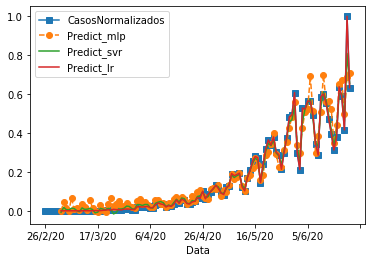

In [9]:
import matplotlib.pyplot as plt
data.plot(y=['CasosNormalizados', 'Predict_mlp', 'Predict_svr', 'Predict_lr'], style=['-s', '--o'])
plt.show()